<!-- dom:TITLE: A tutorial on chaospy -->
# A tutorial on chaospy
<!-- dom:AUTHOR: Leif Rune Hellevik at Department of Structural Engineering, NTNU -->
<!-- Author: --> **Leif Rune Hellevik**, Department of Structural Engineering, NTNU

Date: **Nov 4, 2016**

# The chaospy module

How to import the chaospy module

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *

In [2]:
import chaospy as pc

For convenience we use a very simple model (which may be replaced by
your deterministic model or PDE-solver), namely an exponential decay
function $y(t)$ with two parameters stored in the numpy array 'x':

$$
\begin{equation}
y(t) = x_0 \, e^{-x_1 t}
\label{}
\end{equation}
$$

which may be implemented in python as:

In [3]:
def model_solver(t, x):
    # Simple emulator of a PDE solver 
    return x[0] * e**(-t*x[1])

and may be plotted by:

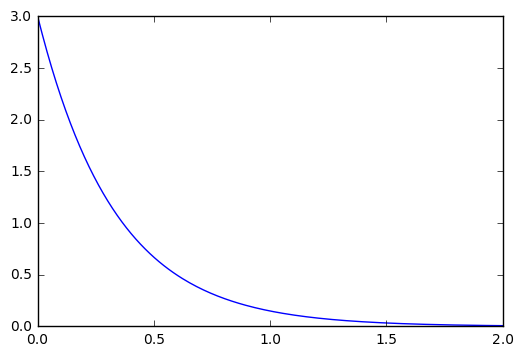

In [4]:
t=linspace(0, 2, 200)
y = model_solver(t, [3,3]) 
plot(t,y)

# Create propability density functions (pdf) for model parameters

### How to create distributions for model parameters

In [5]:
pdf1 = pc.Uniform(0, 1)
pdf2 = pc.Uniform(0, 1)
jpdf = pc.J(pdf1, pdf2)

### Generate solutions of samples of model parameters

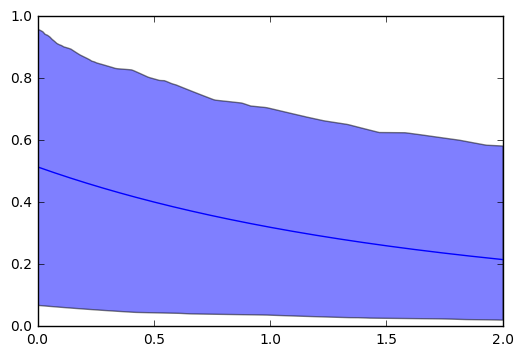

In [6]:
nr_samples=300
X=jpdf.sample(nr_samples)
Y=array([model_solver(t, x) for x in X.T ]) #solve for a given time t=0.5

mu=mean(Y, 0)
p05, p95 = percentile(Y, [5,95], 0)
fill_between(t, p05, p95, alpha=0.5)
plot(t, mu)

### Generate statistics based on the sampled solutions  (Monte Carlo)

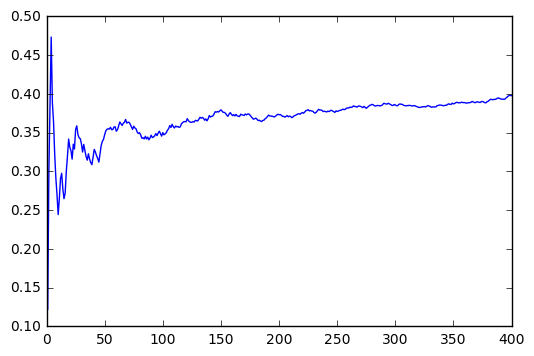

In [7]:
nr_samples=400
X=jpdf.sample(nr_samples)
Y=array([model_solver(0.5, x) for x in X.T ]) #solve for a given time t=0.5
nr_samples_list=arange(nr_samples)+1
converge = cumsum(Y, 0)/nr_samples_list
plot(nr_samples_list, converge)
legstr=[]
legstr.append('random')

### Compare sampling schemes in the parameter space

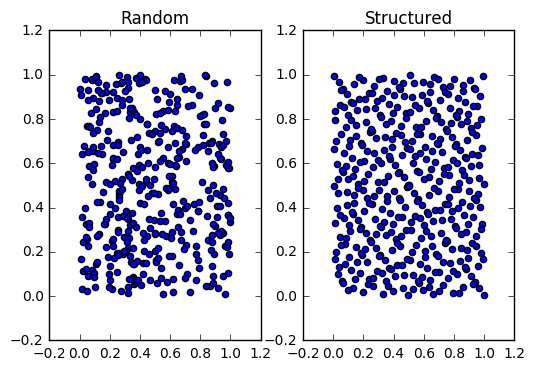

In [8]:
# Various sampling schemes
jpdf = pc.J(pc.Uniform(0,1), pc.Uniform(0,1))
ax1=subplot(121)
ax1.set_title('Random')
X1 = jpdf.sample(nr_samples)
scatter(*X1)
ax2=subplot(122)
X2 = jpdf.sample(nr_samples, "S")
ax2.set_title('Structured')
scatter(*X2)

### Impact of sampling strategy on convergence of Monte Carlo simulations

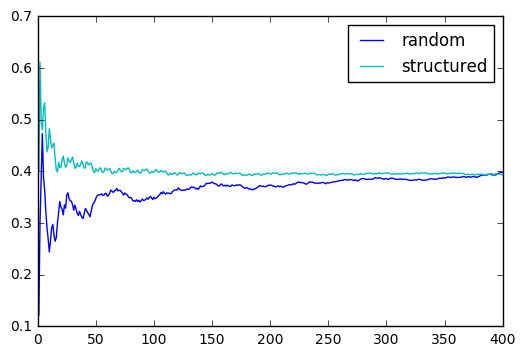

In [9]:
# Effect of sampling on convergence of Monte Carlo simulations
X = jpdf.sample(nr_samples, "S")
Y = [model_solver(0.5, x) for x in X.T]
converge_structured = cumsum(Y, 0)/nr_samples_list

# Compare convergence for random and structured sampling
plot(nr_samples_list, converge)
plot(nr_samples_list, converge_structured, "c")
legend(['random','structured'])

### Polynomial chaos expansions

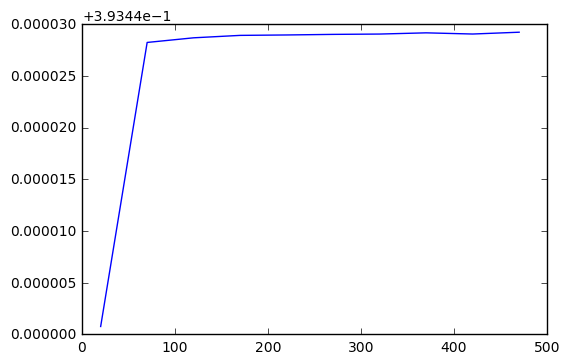

In [10]:
# Polychaos expansions
poly = pc.orth_chol(1, jpdf)
X = jpdf.sample(10, "S")
Y = [model_solver(0.5, x) for x in X.T]

approx = pc.fit_regression(poly, X, Y, rule="T")

nr_poly_samples=np.arange(20,500,50)

order = 3
poly = pc.orth_chol(order+1, jpdf)

mu_values=[]

for psample in nr_poly_samples:
    X = jpdf.sample(psample, "S")
    Y = [model_solver(0.5, x) for x in X.T]
    approx = pc.fit_regression(poly, X, Y, rule="T")
    mu_values.append(pc.E(approx,jpdf))

plot(nr_poly_samples,mu_values)